**Fraudulent Android Application Detector based on network layer features presented by benign and malicious applications**

*   The data used in the model comes from: https://www.kaggle.com/xwolf12/network-traffic-android-malware




In [ ]:
%pip install category_encoders

     |████████████████████████████████| 82 kB 341 kB/s 


In [157]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression as lr
from sklearn import metrics
import matplotlib.pyplot as plt

In [158]:
% cd /content/drive/MyDrive/School [ALU]/Computer Science/Y_4/ML/Summative_Deployment

/content/drive/MyDrive/School [ALU]/Computer Science/Y_4/ML/Summative_Deployment


In [159]:
df = pd.read_csv("android_traffic.csv", sep=";")

# Exploring data

In [160]:
df.head(5)

,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,NaN,NaN,NaN,39,3,benign
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,NaN,NaN,NaN,128,11,benign
2,AntiVirus,196,0,6,24151,0,0,205,214,163887,24867,NaN,NaN,NaN,205,9,benign
3,AntiVirus,6,0,1,889,0,0,7,6,819,975,NaN,NaN,NaN,7,1,benign
4,AntiVirus,6,0,1,882,0,0,7,6,819,968,NaN,NaN,NaN,7,1,benign


In [161]:
df.shape

(7845, 17)

In [162]:
df.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times
count,7845.000000,7845.000000,7845.000000,7.845000e+03,7845.000000,7845.000000,7845.000000,7845.000000,7.845000e+03,7.845000e+03,0.0,0.0,0.0,7845.000000,7845.000000
mean,147.578713,7.738177,2.748502,1.654375e+04,0.056724,0.000255,152.911918,194.706310,2.024967e+05,1.692260e+04,NaN,NaN,NaN,152.911918,4.898917
std,777.920084,51.654222,2.923005,8.225650e+04,1.394046,0.015966,779.034618,1068.112696,1.401076e+06,8.238182e+04,NaN,NaN,NaN,779.034618,18.900478
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000e+00,6.900000e+01,NaN,NaN,NaN,1.000000,0.000000
25%,6.000000,0.000000,1.000000,8.880000e+02,0.000000,0.000000,7.000000,7.000000,9.340000e+02,1.046000e+03,NaN,NaN,NaN,7.000000,1.000000
50%,25.000000,0.000000,2.000000,3.509000e+03,0.000000,0.000000,30.000000,24.000000,4.090000e+03,3.803000e+03,NaN,NaN,NaN,30.000000,3.000000
75%,93.000000,0.000000,4.000000,1.218900e+04,0.000000,0.000000,98.000000,92.000000,2.624400e+04,1.261000e+04,NaN,NaN,NaN,98.000000,5.000000
max,37143.000000,2167.000000,43.000000,4.226790e+06,65.000000,1.000000,37150.000000,45928.000000,6.823516e+07,4.227323e+06,NaN,NaN,NaN,37150.000000,913.000000


# Data cleaning/preparation

In [163]:
# Encode 'type' collumn
encoder = ce.OrdinalEncoder(cols=['type'],return_df=True,
                           mapping=[{'col':'type', 'mapping':{'benign':0,'malicious':1}}])
df = encoder.fit_transform(df)

In [164]:
df.head(4)

,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,NaN,NaN,NaN,39,3,0
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,NaN,NaN,NaN,128,11,0
2,AntiVirus,196,0,6,24151,0,0,205,214,163887,24867,NaN,NaN,NaN,205,9,0
3,AntiVirus,6,0,1,889,0,0,7,6,819,975,NaN,NaN,NaN,7,1,0


In [165]:
# Remove Unnamed collumns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [166]:
# Drop collumns with more than 80% values that NA values or missing values
limiterPer = len(df) * .80
df = df.dropna(thresh=limiterPer, axis=1)

In [167]:
# Check if there are null values in rows
df.isnull().sum()

name                    0
tcp_packets             0
dist_port_tcp           0
external_ips            0
vulume_bytes            0
udp_packets             0
tcp_urg_packet          0
source_app_packets      0
remote_app_packets      0
source_app_bytes        0
remote_app_bytes        0
source_app_packets.1    0
dns_query_times         0
type                    0
dtype: int64

In [168]:
df.head(2)

,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,39,3,0
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,128,11,0


In [169]:
# Set index and remain only with number type data
df.set_index("name", inplace = True)

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7845 entries, AntiVirus to Zsone
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   tcp_packets           7845 non-null   int64
 1   dist_port_tcp         7845 non-null   int64
 2   external_ips          7845 non-null   int64
 3   vulume_bytes          7845 non-null   int64
 4   udp_packets           7845 non-null   int64
 5   tcp_urg_packet        7845 non-null   int64
 6   source_app_packets    7845 non-null   int64
 7   remote_app_packets    7845 non-null   int64
 8   source_app_bytes      7845 non-null   int64
 9   remote_app_bytes      7845 non-null   int64
 10  source_app_packets.1  7845 non-null   int64
 11  dns_query_times       7845 non-null   int64
 12  type                  7845 non-null   int64
dtypes: int64(13)
memory usage: 858.0+ KB


In [171]:
# Return rows of datafram in random order to benefit splitting
df = df.sample(frac=1)

In [172]:
df.head(4)

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,dns_query_times,type
name,,,,,,,,,,,,,
Communication,32,0,2,11555,0,0,35,34,3832,11632,35,1,0
AntiVirus,6,0,1,881,0,0,7,6,819,967,7,1,0
MediaAndVideo,6,0,1,1055,0,0,7,7,750,1129,7,1,0
BaseBridge,0,0,0,0,0,0,3,3,497,235,3,3,1


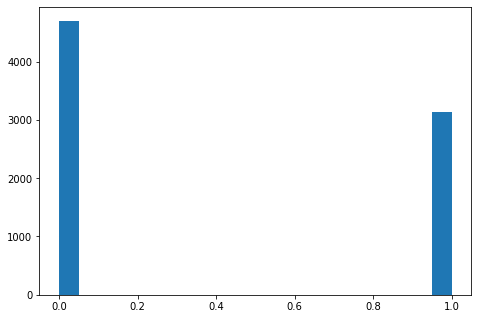

In [173]:
# Plot number of benign and malicious apps
# Where, benign is '0' and malicious is '1'
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.hist(df['type'], 20)
plt.show()

# Find relevant features

In [174]:
# Using Pearson Correlation
cor = df.corr(method ='pearson')

In [175]:
# Correlation with output variable Overall Ranking
cor_target = abs(cor['type'])
# Selecting highly correlated features (correlation coefficient above 0.6)
relevant_features = cor_target[cor_target>0.05]
relevant_features

tcp_packets             0.078641
dist_port_tcp           0.086772
external_ips            0.247536
vulume_bytes            0.067534
source_app_packets      0.078329
remote_app_packets      0.074458
source_app_bytes        0.063112
remote_app_bytes        0.067577
source_app_packets.1    0.078329
type                    1.000000
Name: type, dtype: float64

In [176]:
# Getting relevant Columns (in format of an Array)
relevant_cols = relevant_features.index.array.to_numpy()
relevant_cols

array(['tcp_packets', 'dist_port_tcp', 'external_ips', 'vulume_bytes',
       'source_app_packets', 'remote_app_packets', 'source_app_bytes',
       'remote_app_bytes', 'source_app_packets.1', 'type'], dtype=object)

In [177]:
# Create dataframe with relevant collumns
df = df.filter(relevant_cols, axis=1)

In [178]:
# Remove last 20 rows to use in application as test after deployment
# df_app = df.tail(4)
# df_app.to_csv('4_apps_to_test_app.csv')
df = df.iloc[:-4 , :]

In [179]:
df.head(4)

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,source_app_packets.1,type
name,,,,,,,,,,
Communication,32,0,2,11555,35,34,3832,11632,35,0
AntiVirus,6,0,1,881,7,6,819,967,7,0
MediaAndVideo,6,0,1,1055,7,7,750,1129,7,0
BaseBridge,0,0,0,0,3,3,497,235,3,1


# Split DF into train and test dataframes

In [180]:
# Split into training and test data : 75 training and 25 testing
x = df.drop(labels=['type'], axis = 1)
y = df['type']
x_train, x_test, y_train, y_test = tts(x, y, test_size = 0.25)

## Linear Regresion Model

In [183]:
lr_model = lr()
lr_model.fit(x_train, y_train)

LinearRegression()

In [185]:
# Making Predictions From the Model
predictions = lr_model.predict(x_test)

In [186]:
# Mean Squared Error (MSE) - 
metrics.mean_squared_error(y_test, predictions)

0.2255453159038141

In [189]:
# R2 Score
metrics.r2_score(y_test, predictions)

0.06934653468815333

## Random Forest

In [193]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score 

In [192]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_model = clf.fit(x_train, y_train)

In [194]:
# Evaluation
pred_test = rf_model.predict(x_test)
accuracy_score(y_test,pred_test)

0.7312595614482407

## Neural Network

In [195]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [196]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=54, activation= "relu"))
nn_model.add(Dense(8, activation = 'relu'))
nn_model.add(Dense(4, activation = 'relu'))
nn_model.add(Dense(1, activation = 'sigmoid'))
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                660       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


In [197]:
# Compile model
nn_model.compile(loss= "binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
# Fit model
nn_model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5


ValueError: ignored